In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings

warnings.filterwarnings(action='ignore')

data_dir = '../RecsysPaper_Code_Review/files/ml-latest-small/'
model_dir = '../RecsysPaper_Code_Review/model/BPR/'

# 데이터 확인

In [3]:
ratings_df = pd.read_csv(data_dir + 'ratings.csv')
ratings_df.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [4]:
num_user = ratings_df['userId'].nunique()
num_item = ratings_df['movieId'].nunique()

sparsity = 1 - len(ratings_df) / (num_user * num_item)

print(f'전체 User 수: {num_user}')
print(f'전체 Item 수: {num_item}')
print(f'행렬의 희소성: {sparsity:.4f}')

전체 User 수: 610
전체 Item 수: 9724
행렬의 희소성: 0.9830


Text(0.5, 1.0, 'Rating distribution')

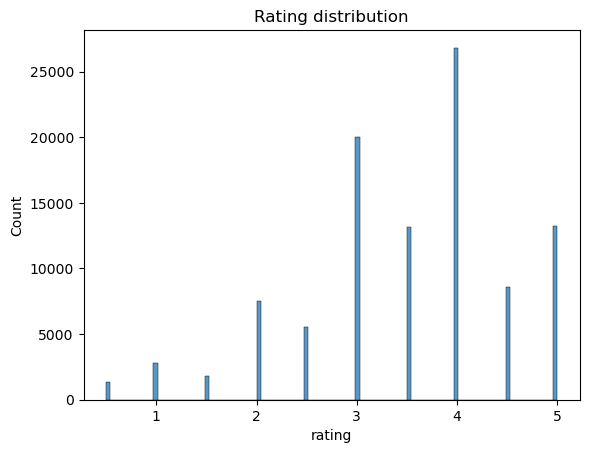

In [6]:
sns.histplot(ratings_df['rating'])
plt.title('Rating distribution')

In [7]:
mu = ratings_df['rating'].mean()

# 데이터셋 제작

In [8]:
def split_data(df, test_ratio = 0.1):
    user_id_li = df['userId'].unique()
    mask = []
    for user_id in user_id_li:
        _df = df[df['userId'] == user_id]
        mask += [True if x == 1 else False for x in np.random.uniform(0, 1, (len(_df))) < 1 - test_ratio]
    neg_mask = [not x for x in mask]

    train_data, test_data = df[mask], df[neg_mask]
    return train_data, test_data

train_df, val_df = split_data(df = ratings_df)

In [9]:
not_in_val_user_num = len(set(val_df['userId'].unique().tolist()) - set(train_df['userId'].unique().tolist()))
not_in_val_item_num = len(set(val_df['movieId'].unique().tolist()) - set(train_df['movieId'].unique().tolist()))

print(f'학습용 데이터에 없는 유저의 수 : {not_in_val_user_num}')
print(f'학습용 데이터에 없는 영화의 수 : {not_in_val_item_num}')
print(f'학습용 데이터의 수: {len(train_df)}, 평가용 데이터의 수: {len(val_df)}')

학습용 데이터에 없는 유저의 수 : 0
학습용 데이터에 없는 영화의 수 : 355
학습용 데이터의 수: 90665, 평가용 데이터의 수: 10171


In [10]:
user_encoder, user_decoder = {}, {}
for idx, user_id in enumerate(ratings_df['userId'].unique()):
    user_encoder[user_id] = idx
    user_decoder[idx] = user_id

item_encoder, item_decoder = {}, {}
for idx, item_id in enumerate(ratings_df['movieId'].unique()):
    item_encoder[item_id] = idx
    item_decoder[idx] = item_id

In [11]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, user_encoder, item_encoder):
        self.df = df
        self.user_encoder, self.item_encoder, = user_encoder, item_encoder
        self.user = torch.tensor([self.user_encoder[i] for i in self.df['userId'].tolist()])
        self.item = torch.tensor([self.item_encoder[i] for i in self.df['movieId'].tolist()])
        self.rating = torch.tensor(self.df['rating'].tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = self.user[idx]
        item = self.item[idx]
        rating = self.rating[idx]

        return user, item, rating

# 모델 정의

In [12]:
from matplotlib import path
class MF(nn.Module):
    def __init__(self, num_user, num_item, num_factor, mu):
        super(MF, self).__init__()
        self.P = nn.Embedding(num_user, num_factor)
        self.Q = nn.Embedding(num_item, num_factor)
        self.user_bias = nn.Embedding(num_user, 1)
        self.item_bias = nn.Embedding(num_item, 1)
        self.mu = mu

    def forward(self, user, item):
        p_u = self.P(user)
        q_i = self.Q(item)
        b_u = self.user_bias(user)
        b_i = self.item_bias(item)
        mu = self.mu

        output = torch.sum((p_u * q_i), axis = 1) + torch.squeeze(b_u) + torch.squeeze(b_i) + mu
        
        return output.view(-1)

# 학습 설정

In [13]:
def train(model, train_loader):
    model.train()
    train_loss = 0

    for user, item, rating in train_loader:
        user = user.to(device)
        item = item.to(device)
        rating = rating.to(device)

        optimizer.zero_grad()
        output = model(user, item)

        loss = criterion(output, rating)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)

    return train_loss


def evaluate(model, test_loader):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for user, item, rating in test_loader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device)

            output = model(user, item)

            loss = criterion(output, rating)

            test_loss += loss.item()

    test_loss = test_loss / len(test_loader)

    return test_loss

# 학습

In [14]:
num_factor = 100
batch_size = 128
epochs = 30
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lr = 0.005

In [15]:
model = MF(num_user = num_user, num_item = num_item, num_factor = num_factor, mu = mu).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

train_dataset = CustomDataset(df = ratings_df, user_encoder = user_encoder, item_encoder = item_encoder)
val_dataset = CustomDataset(df = val_df, user_encoder = user_encoder, item_encoder = item_encoder)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, drop_last = False)

In [16]:
best_metric = 1

for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader)
    val_loss = evaluate(model, val_loader)

    print(f"[EPOCH: {epoch}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_metric:
        best_metric = val_loss
        torch.save(model.state_dict(), model_dir + f'Matrix_Factorization.pt')

[EPOCH: 1], Train Loss: 76.9959, Val Loss: 27.9113
[EPOCH: 2], Train Loss: 23.4465, Val Loss: 9.9721
[EPOCH: 3], Train Loss: 9.1389, Val Loss: 4.2465
[EPOCH: 4], Train Loss: 4.2365, Val Loss: 2.2340
[EPOCH: 5], Train Loss: 2.3448, Val Loss: 1.5708
[EPOCH: 6], Train Loss: 1.6804, Val Loss: 1.5680
[EPOCH: 7], Train Loss: 1.6588, Val Loss: 1.8697
[EPOCH: 8], Train Loss: 1.9751, Val Loss: 2.1665
[EPOCH: 9], Train Loss: 2.1570, Val Loss: 1.9757
[EPOCH: 10], Train Loss: 1.9098, Val Loss: 1.6176
[EPOCH: 11], Train Loss: 1.5543, Val Loss: 1.4129
[EPOCH: 12], Train Loss: 1.3591, Val Loss: 1.4477
[EPOCH: 13], Train Loss: 1.3524, Val Loss: 1.4558
[EPOCH: 14], Train Loss: 1.4073, Val Loss: 1.4239
[EPOCH: 15], Train Loss: 1.3818, Val Loss: 1.2954
[EPOCH: 16], Train Loss: 1.2382, Val Loss: 1.1947
[EPOCH: 17], Train Loss: 1.1179, Val Loss: 1.1609
[EPOCH: 18], Train Loss: 1.0596, Val Loss: 1.1128
[EPOCH: 19], Train Loss: 1.0335, Val Loss: 1.0895
[EPOCH: 20], Train Loss: 1.0022, Val Loss: 0.9868
[EPOCH

본 학습에서 Embedding 한쪽을 고정시킨 후에 학습을 진행하면 ALS 방식이 된다. 그리고 데이터의 구조를 조금더 바꾸면 시간에 대한 역동성도 반영할 수 있고, 신뢰도를 추가하여 학습을 진행할 수도 있다.